# Vaje 10: Krčenje razsežnosti podatkov

## Naloga 1: Rangiranje podatkov

Najprej se bomo ukvarjali z rangiranjem in izbiro spremenljivk. Za rangiranje spremenljivk moramo najprej oceniti njihovo pomembnost. Rangiranje in ocenjevanje pomembnosti spremenljivk je zanimivo že za interpretacijo podatkov, uporabno pa je tudi za učenje napovednih modelo, na primer za izbiro manjše množice pomembnih spremenljivk, ali pa za uteževanje spremenljivk pri učenju modelov.

Obstaja veliko metod za ocenjevanje pomembnosti spremenjivk. Ločimo jih po tem, ali izhajajo iz napovednega modela (kot na primer pomembnosti pri drevesnih modelih). 
Metode, ki so od modelov neodvisne, dalje ločimo na nadzorovane in nenadzorovane glede na to, ali upoštevajo ciljno spremenljivko.

Ker izbira spremenljivk vpliva na izbiro napovednega modela je zelo pomembno, da pomembnost spremenljivk ocenjujemo le na učni množici.

1.a: Preberi podatke iz datoteke `vaje10.npz` in jih razdeli v učno in testno množico. Učna množica naj vsebuje približno 80% podatkov, testna pa preostale.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = np.load("../Podatki/vaje10.npz")
X = data["x"]
y = data["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Začnimo z najpreprostejšo, nenadzorovano metodo, pri kateri za pomembnejše spremenljivke označimo tiste z višjo varianco.

(Opomba: v primeru kategoričnih spremenljivk se računa entropija.)  

1.b: Učne podatke skaliraj na interval [0, 1] in izračunaj varianco vsake spremenljivke. Izračunaj rangiranje spremenljivk ter nariši rangirni graf (x-os: spremenljivke urejene po padajoči pomembnosti, y-os: pomembnost spremenljivk).

In [3]:
import matplotlib.pyplot as plt

In [4]:
X_scaled = (X_train - X_train.min(axis=0))/(X_train.max(axis=0)-X_train.min(axis=0))
variances = np.var(X_scaled, axis=0)
sorted_variances = np.flip(np.sort(variances))
variance_indices = np.argsort(-variances)

[0.01439165 0.00072479 0.00071291 0.0007114  0.00067944 0.00066994
 0.00056149 0.00054912 0.00054879 0.00051667]
[28 27  7 16 60 31 57 50  2 42]


[]

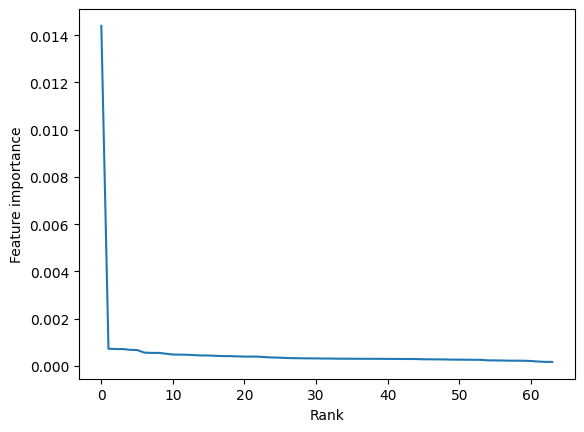

In [5]:
print(sorted_variances[:10])
print(variance_indices[:10])
plt.plot(sorted_variances)
plt.xlabel("Rank")
plt.ylabel("Feature importance")
plt.plot()

Naslednja metoda je primer nadzorovane metode ocenjevanja pomembnosti na podlagi statističnega testa. Ker pri tej metodi ignoriramo povezave med različnimi stolpci, spada med uni-variantne metode.

V naših podatkih so vsi X numerični, Y pa je dvojiški, tako da bo ustrezen test *Welchov t-test*, ki ga v scipy-ju lahko najdemo pod imenom `scipy.stats.ttest_ind` s parametrom `equal_var=False`. 

1.c: Učno množico razdeli na množici pozitivnih in negativnih primerov in za vsako spremenljivko izračunaj pomembnost z "Welchovim t-testom" (nižja p-vrednost => spremenljivka je bolj pomembna). Izračunaj rangiranje spremenljivk ter nariši rangirni graf.

In [6]:
from scipy.stats import ttest_ind

In [7]:
positive_X = X_train[y_train.astype(bool), :]
negative_X = X_train[(1-y_train).astype(bool), :]

print(positive_X.shape, negative_X.shape)

p_values = []
for i in range(X_train.shape[1]):
    p_values.append(ttest_ind(positive_X[:, i], negative_X[:, i], equal_var=False).pvalue)

(1649, 64) (1783, 64)


[1.66790029e-14 5.05704186e-07 3.90249371e-04 1.35857470e-03
 3.24539107e-03 9.11605213e-03 1.72659807e-02 1.82669910e-02
 2.15007616e-02 2.37388885e-02]
[28  0 54 60 14 24  1 56  5  9]


[]

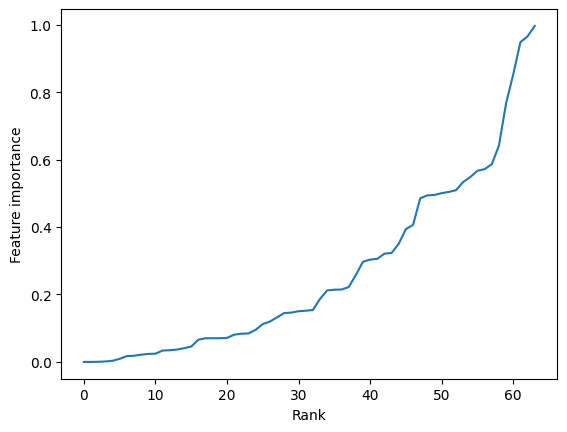

In [8]:
sorted_p_values = np.sort(p_values)
sorted_indices = np.argsort(p_values)

print(sorted_p_values[:10])
print(sorted_indices[:10])
plt.plot(sorted_p_values)
plt.xlabel("Rank")
plt.ylabel("Feature importance")
plt.plot()

Zadnja metoda, ki jo bomo preizkusili, je algoritem *Relief*. Gre za popularno metodo, ki upošteva tudi interakcije med napovednimi spremenljivkami (Višja vrednost => bolj pomembna spremenljivka)

1.d: S pomočjo knjižnjice [`sklearn-relief`](https://gitlab.com/moongoal/sklearn-relief) izračunaj pomembnost spremenljivk z algoritmom Relief ali RReliefF, jih rangiraj in nariši rangirni graf. 

<details>
  <summary>Namig:</summary>

  *Vhodni podatki v algoritem RReliefF morajo biti skalirani na interval [0,1]. Knjižnjica `sklearn-relief` uporablja isti uporabniški vmesnik kot sklearn zato lahko pomembnost spremenljivk ocenimo z metodo fit, podatke pa spremenimo iz originalnega prostora v preslikan prostor z metodo transform. Pomembnost spremenljivk lahko najdemo v spremenljivki w_*.

  ```
  import sklearn_relief
  relief = sklearn_relief.Relief(n_features=10)
  ...
  print(relief.w_)
  ``` 
   
</details>

In [9]:
!pip install sklearn-relief

In [10]:
import sklearn_relief as sr

In [11]:
relief = sr.Relief(n_features=10)
relief = relief.fit(X_scaled, y_train)

[0.01016421 0.01013223 0.01005092 0.00903377 0.00884915 0.00802708
 0.0063657  0.00459294 0.00334016 0.00329022]
[50  2 61 24  1 51  5 28 29 56]


[]

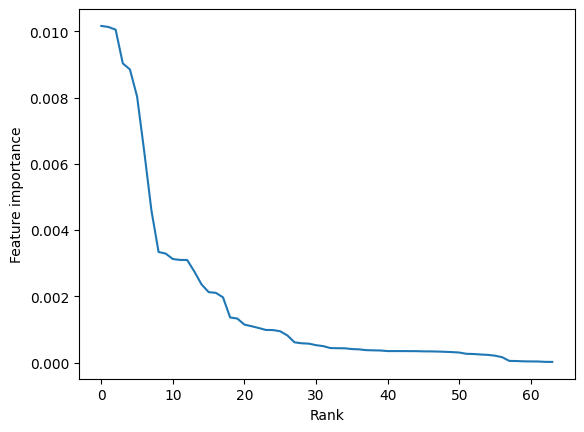

In [12]:
sorted_relief_values = np.flip(np.sort(relief.w_))
sorted_relief_indices = np.flip(np.argsort(relief.w_))

print(sorted_relief_values[:10])
print(sorted_relief_indices[:10])
plt.plot(sorted_relief_values)
plt.xlabel("Rank")
plt.ylabel("Feature importance")
plt.plot()

1.e: Izberi 10 najbolj pomembnih spremenljiv glede na ocene pomembnosti iz nalog 1.b, 1.c in 1.d. Za vsako podmnožico spremenljivk preveri točnost odločitvenega drevesa na testni množici.

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [14]:
model_var = DecisionTreeClassifier().fit(X_scaled[:, variance_indices[:10]], y_train)
model_ttest = DecisionTreeClassifier().fit(X_scaled[:, sorted_indices[:10]], y_train)
model_relief = DecisionTreeClassifier().fit(relief.transform(X_scaled), y_train)

scaled_test = (X_test - X_train.min(axis=0))/(X_train.max(axis=0)-X_train.min(axis=0))

pred_var = model_var.predict(scaled_test[:, variance_indices[:10]])
pred_ttest = model_ttest.predict(scaled_test[:, sorted_indices[:10]])
pred_relief = model_relief.predict(relief.transform(scaled_test))

print(f"Var accuracy: {accuracy_score(y_test, pred_var)}")
print(f"TTest accuracy: {accuracy_score(y_test, pred_ttest)}")
print(f"Relief accuracy: {accuracy_score(y_test, pred_relief)}")

Var accuracy: 0.5913853317811408
TTest accuracy: 0.6623981373690337
Relief accuracy: 0.6426076833527358


## Naloga 2: Metoda glavnih komponent

Krčenje razsežnosti podatkov smo si na hitro pogledali že na drugih vajah o nevronskih mrežah (samokodirnik) in na vajah o gručenju (TSNE). Sedaj si bomo pogledali še najbolj popularno metodo za transformacijo podatkov v prostor nižje razsežnosti, metodo glavnih komponent (PCA - principle component analysis). Prva glavna komponenta je linearna kombinacija napovednih spremenljivk, ki povzame največ variance v podatkih. Druga glavna komponenta je pravokotna na prvo ter povzame največ variance v podatkih ki ostanejo, ko jim odstranimo prvo komponento. Z nadaljevanjem postopka pridobimo p komponent.

Pri metodi PCA ponavadi rišemo graf "scree". Na x-osi ima glavne komponente, na y-osi pa delež variance, ki ga vsaka glavna komponenta pojasni.
Pogosto je lažje berljiv graf kumulativne variance, kjer za i-to glavno komponento na y-osi narišemo delež variance,
ki ga skupaj pojasnijo vse komponente do vključno i-te.

2.a: Izračunaj glavne komponente in nariši "scree" graf z dvema krivuljama: Delež pojasnjene variance in komulativni delež pojasnjene variance.

<details>
  <summary>Namig:</summary>

  *Pomagaš si lahko z [objektom sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)* in atributom `explained_variance_ratio_`, ki vsebuje seznam z deleži pojasnjene variance za vsako glavno komponento.
</details>

In [15]:
from sklearn.decomposition import PCA

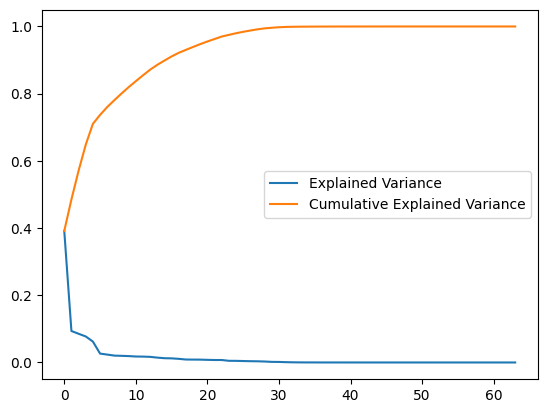

In [16]:
pca = PCA().fit(X_scaled)
explained_variances = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variances)

plt.plot(explained_variances, label="Explained Variance")
plt.plot(cumulative_explained_variance, label="Cumulative Explained Variance")
plt.legend()
plt.show()

2.b: Metoda glavnih komponent se včasih uporablja tudi za vizualizacijo visoko dimenzionalnih podatkov. Nariši graf, ki ima na x-osi vrednosti prve glavne komponente, na y-osi pa vrednosti druge glavne komponente. Uporabi skalirane podatke, logaritemsko skalo in z različnima barvama loči pozitivne in negativne primere.

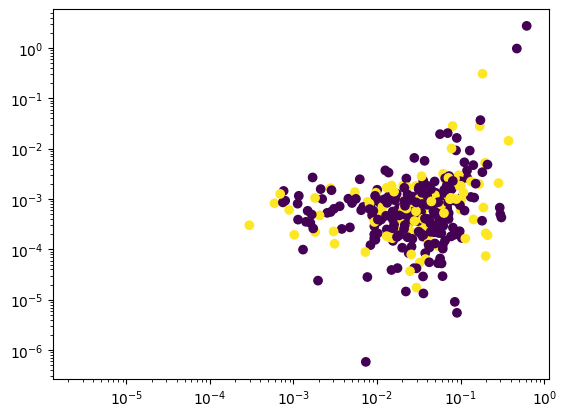

In [17]:
transformed_data = PCA(n_components=2).fit_transform(X_scaled)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=y_train)
plt.xscale("log")
plt.yscale("log")
plt.show()

Končno uporabimo PCA še za učenje napovednega modela. Kot napovedne spremenljivke modelu namesto originalnih podatkov podamo M glavnih komponent.

2.c: Izračunaj točnost modela odločitvenih dreves na originalnem in na transformiranem prostoru. Pri kakšnem številu glavnih komponent je točnost modela najvišja?

In [18]:
from sklearn.tree import DecisionTreeClassifier

Accuracy with scaled data: 0.8020954598370198


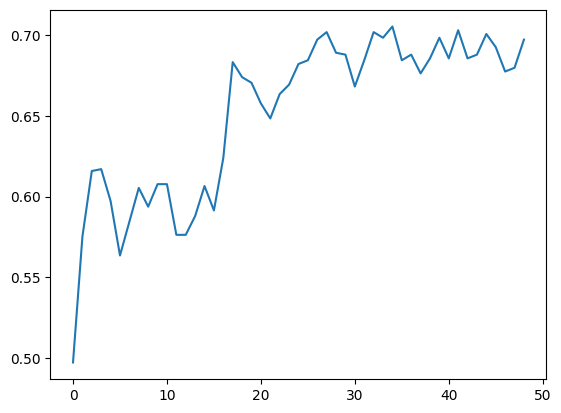

In [21]:
model = DecisionTreeClassifier().fit(X_scaled, y_train)
y_pred = model.predict(scaled_test)
print(f"Accuracy with scaled data: {accuracy_score(y_test, y_pred)}")

pca_accuracies = []

for i in range(1, 50):
    pca = PCA(n_components=i).fit(X_scaled)
    pca_train = pca.transform(X_scaled)
    pca_test = pca.transform(scaled_test)
    model = DecisionTreeClassifier().fit(pca_train, y_train)
    y_pred = model.predict(pca_test)
    score = accuracy_score(y_test, y_pred)
    pca_accuracies.append(score)
    # print(f"Accuracy with transformed data with dimension {i}: {score}")
    
plt.plot(pca_accuracies)
plt.show()

Vidimo, da točnost modela neha naraščati pri približno 30, kar se sklada z grafom iz naloge 2.a, kjer se delež razložene variance pri 30 komponentah približuje 1.

V praksi število komponent izberemo glede z uporabo "scree" grafa. Pogledamo pri katerem številu komponent delež pojasnjene variance neha bistveno naraščati oziroma izberemo število komponent pri katerem smo zadovoljni z razmerjem med deležem in številom komponent.

Glavna omejitev metode glavnih kompoment je njena linearnost. 
Nekaj popularnih nelinearnih metod za krčenje razsežnosti podatkov:
- samokodirniki
- t-SNE
- UMAP
